In [2]:

import sys 
import os
from datetime import datetime
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(os.getcwd()))

import pooldata as p_data
import JIT_funcs as JIT

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Parameters of the case to analyze
begin=datetime(2022,6,1)
end=datetime(2022,8,7)
pools=p_data.query_top_pools(900,'volumeUSD')
pools['pool']=pools['pool_name'].str.split("-").str[0:2]
#Keeping only ETH/Stables pools
# pools=pools.loc[pools['pool'].isin([['USDC','WETH'],['WETH','USDT'],['DAI','WETH']])]
pools_adresses=pools['id'].to_list()

In [5]:
pools

,id,createdAtTimestamp,feeTier,volumeUSD,token0.symbol,token0.decimals,token0.derivedETH,token1.symbol,token1.decimals,token1.derivedETH,pool_name,pool
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,1620250931,500,11789226708167692.7160727353369959,USDC,6,7847.312295897616432848906579685981,WETH,18,1,USDC-WETH-500,"[USDC, WETH]"
1,0x3416cf6c708da44db2624d63ea0aaef7113527c6,1636825557,100,8325017670017065.536592634933158032,USDC,6,7847.312295897616432848906579685981,USDT,6,7849.106358968110115282966195831775,USDC-USDT-100,"[USDC, USDT]"
2,0x11b815efb8f581194ae79006d24e0d814b7697f6,1620251172,500,1769507386391621.037135041593837856,WETH,18,1,USDT,6,7849.106358968110115282966195831775,WETH-USDT-500,"[WETH, USDT]"
3,0x5e35c4eba72470ee1177dcb14dddf4d9e6d915f4,1639537868,100,1744775230616770.849361109892030438,BUSD,18,7841.946541728502455596225663422198,USDC,6,7847.312295897616432848906579685981,BUSD-USDC-100,"[BUSD, USDC]"
4,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,1620246230,500,1443976029991758.505766084292386492,WBTC,8,130582425.2454012952998121870939045,WETH,18,1,WBTC-WETH-500,"[WBTC, WETH]"
...,...,...,...,...,...,...,...,...,...,...,...,...
895,0x86347ace0fbf4e408c0183622e9c063ca5a2258a,1638395984,10000,107482391.3572504639060600836651802,WETH,18,1,LIT,18,0.00000002086978929985105054492836469950138,WETH-LIT-10000,"[WETH, LIT]"
896,0x506b8008f00ce55299d6cbb640bc390751226bcc,1667607059,10000,106470826.0307895196091889649747148,KC,18,0,USDC,6,7847.312295897616432848906579685981,KC-USDC-10000,"[KC, USDC]"
897,0x2b1b8052eed6467967d047b58b71f8e9ffa057b5,1627801422,3000,105785426.1551431141397839501060636,CIV,18,0.00002344569368371638990954611376111185,WETH,18,1,CIV-WETH-3000,"[CIV, WETH]"
898,0x41351b1f6e31aef6057a08592f1b7d539c2b1869,1642683445,3000,105029334.0277093210683073770938461,LUXO,18,0,USDT,6,7849.106358968110115282966195831775,LUXO-USDT-3000,"[LUXO, USDT]"


In [ ]:
#Loop to get a dataframe with all JIT operations happened in the given dataframe for every pool in the list
# 寻找一个合适的池子来分析，因为the graph上一些小池子的数据不是很全面，所以要找一个数据全的
for idx,pool_adress in enumerate(pools_adresses):
    
    #Handling pools with no JIT operations with a try/except
    try:
        
        #Using JIT_funcs to obtain all JIT operations
        jit_final=JIT.JIT_pool(begin,end,pool_adress)
        
        #Using poolDayData to obtain the total fees generated by the pool
        pool_data=p_data.extract_pooldayData(begin,end,pool_adress)
        pool_data['feesUSD']=pool_data['feesUSD'].astype(float)
        pool_data['feesUSD_ac_pool']=pool_data['feesUSD'].cumsum()
        pool_data['date']=pool_data['timestamp_1'].dt.date
        jit_final['date']=jit_final['timestamp_1'].dt.date

        #Merging pool data with JIT data in order to compare it
        jit_final=jit_final.merge(pool_data[['date','feesUSD_ac_pool']],how='left',left_on='date',right_on='date')

        #Ratio of fees extracted by JIT operations
        ratio_extracted=jit_final['feesUSD'].sum()/pool_data['feesUSD'].sum()
        
        #Storing data with a readable pool_id
        pool_name=pools['pool_name'].iloc[idx]
        jit_final['pool_name']=pool_name
        #Saving to a csv
        jit_final.to_csv(path_result+"\\%s.csv" %(pool_adress))
        #Creating a summary in a dict
        results[pool_name]={
            'feesUSD': pool_data['feesUSD'].sum() ,
            'feesExtracted':jit_final['feesUSD'].sum() ,
            'ratio_extracted': round(ratio_extracted,5) ,
        }
        print(results)

    except: 
        print("%s doesnt have JIT operations" %(pools['pool_name'].iloc[idx]))
        results[pools['pool_name'].iloc[idx]]={ 'ratio_extracted': 'No JIT operations' }
        pass

In [24]:
# 随便拿一个池子进行分析 这个是usdc和eth的池子地址
# 0.3% USDC/ETH pool
pool_adress = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
pool_data=p_data.extract_pooldayData(begin,end,pool_adress)
pool_data

,id,date,volumeToken0,volumeToken1,volumeUSD,feesUSD,timestamp_1
1,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19145,1654128000,62382465.09672,33199.507076422365240498,62408905.27085463790806513088395863,187226.7158125639137241953926518767,2022-06-02
2,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19146,1654214400,50199845.438449,27645.452742935151671245,50192714.34220480498666896822943479,150578.1430266144149600069046883045,2022-06-03
3,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19147,1654300800,35417698.11771,19919.120632935320504959,35429746.35075298195670295016238497,106289.2390522589458701088504871548,2022-06-04
4,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19148,1654387200,18651711.812883,10463.208967685027281738,18640510.49400598685293962886920096,55921.53148201796055881888660760285,2022-06-05
5,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19149,1654473600,22044061.664104,12228.369549246050126019,22040372.7144207093699098585296736,66121.11814326212810972957558902075,2022-06-06
...,...,...,...,...,...,...,...
195,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19339,1670889600,11170173.592526,8887.355791522809368277,11166856.65147639381667578548815613,33500.56995442918145002735646446843,2022-12-13
196,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19340,1670976000,34675059.888959,26553.356626226622920728,34638706.73890242869575434017947713,103916.1202167072860872630205384309,2022-12-14
197,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19341,1671062400,26143592.313941,19755.894088290539695043,26162608.72348922296648998665020116,78487.82617046766889946995995060349,2022-12-15
198,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19342,1671148800,14707109.455761,11488.816083203749239123,14729242.53270197676802501317795175,44187.72759810593030407503953385524,2022-12-16


In [25]:
pool_data.dtypes

id                      object
date                     int64
volumeToken0            object
volumeToken1            object
volumeUSD               object
feesUSD                 object
timestamp_1     datetime64[ns]
dtype: object

In [26]:
pool_data['feesUSD']=pool_data['feesUSD'].astype(float)
pool_data['volumeToken1'] = pool_data['volumeToken1'].astype(float)
pool_data['volumeToken0'] = pool_data['volumeToken0'].astype(float)
# cumsun 是计算累加值（增量
# feeUSD是一段时间内的fee，feesUSD_ac_pool是从开始时刻到现在的累加值（全量
pool_data['feesUSD_ac_pool']=pool_data['feesUSD'].cumsum()
pool_data['date']=pool_data['timestamp_1'].dt.date

In [27]:
pool_data

,id,date,volumeToken0,volumeToken1,volumeUSD,feesUSD,timestamp_1,feesUSD_ac_pool
1,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19145,2022-06-02,6.238247e+07,33199.507076,62408905.27085463790806513088395863,187226.715813,2022-06-02,1.872267e+05
2,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19146,2022-06-03,5.019985e+07,27645.452743,50192714.34220480498666896822943479,150578.143027,2022-06-03,3.378049e+05
3,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19147,2022-06-04,3.541770e+07,19919.120633,35429746.35075298195670295016238497,106289.239052,2022-06-04,4.440941e+05
4,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19148,2022-06-05,1.865171e+07,10463.208968,18640510.49400598685293962886920096,55921.531482,2022-06-05,5.000156e+05
5,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19149,2022-06-06,2.204406e+07,12228.369549,22040372.7144207093699098585296736,66121.118143,2022-06-06,5.661367e+05
...,...,...,...,...,...,...,...,...
195,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19339,2022-12-13,1.117017e+07,8887.355792,11166856.65147639381667578548815613,33500.569954,2022-12-13,4.185511e+07
196,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19340,2022-12-14,3.467506e+07,26553.356626,34638706.73890242869575434017947713,103916.120217,2022-12-14,4.195903e+07
197,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19341,2022-12-15,2.614359e+07,19755.894088,26162608.72348922296648998665020116,78487.826170,2022-12-15,4.203752e+07
198,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8-19342,2022-12-16,1.470711e+07,11488.816083,14729242.53270197676802501317795175,44187.727598,2022-12-16,4.208171e+07


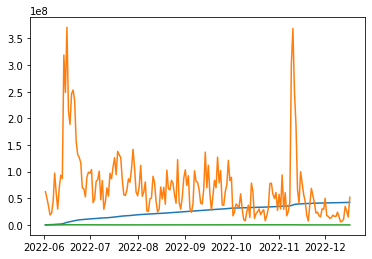

In [30]:
x = pool_data["date"]
fees = pool_data["feesUSD_ac_pool"]
reserve0 = pool_data["volumeToken0"]
reserve1 = pool_data["volumeToken1"]
plt.plot(x, fees)
plt.plot(x, reserve0)
plt.plot(x, reserve1)
plt.show()
